In [1]:
%pylab inline
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import sys
import numpy as np
os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')

import mneflow

# Dataset parameters
dpath = '/m/nbe/scratch/strokemotor/healthysubjects/'
# fname = 'sub1/short_epochs.fif'
fnames = [''.join([dpath, 'sub', str(ii), '/long_epochs.fif']) for ii in range(2, 3)]

import_opt = dict(fs=1000,
                  savepath='../tfr/',
                  out_name='stm_seq',
                  input_type='seq',
                  overwrite=False,
                  val_size=0.2,
                  # array_keys={'X': 'train_data', 'y': 'train_dg'},
                  # picks=np.arange(0,306,3),
                  bp_filter=(.1, 125),
                  # target_picks=None,
                  target_type='int',
                  segment=250,
                  augment=True,
                  aug_stride=100,
                  # transpose=('X', 'y'),
                  combine_events={3: 0, 4: 1, 5: 1, 6: 0, 2: 2},
                  scale=True,
                  scale_interval=(0, 1000),
                  decimate=None,
                  # transform_targets=False,
                  seq_length=None,
                  test_set='holdout'
                  )

meta = mneflow.produce_tfrecords(fnames, **import_opt)

nbatch = 12
steps = int(144/nbatch)

# batch the dataset according to that value
dataset = mneflow.Dataset(meta, train_batch=nbatch, class_subset=None,
                          pick_channels=None, decim=None)


Populating the interactive namespace from numpy and matplotlib
Metadata file found, restoring


In [2]:
import sys
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 1.14.0
executing eagerly: False
---------


In [3]:
# training parameters
#optimizer_params = dict(l1_lambda=3e-4,learn_rate=3e-4, task='classification')
optimizer_params = dict(l2_lambda=3e-3, l1_scope=['fc'], l1_lambda=3e-4,
                        l2_scope=['dmx', 'tconv'], learn_rate=3e-4,
                        task='classification') # l1_scope=['fc'], , l2_scope=['dmx', 'tconv']

optimizer = mneflow.Optimizer(**optimizer_params)
# model parameters
graph_specs = dict(n_ls=32,  # number of latent factors
                   filter_length=32,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   model_path=meta['savepath'],
                   dropout=.5,)

model = mneflow.models.LFLSTM(dataset,optimizer,graph_specs)
#model = mneflow.models.VARCNN(dataset,optimizer,graph_specs)

model.build()

X0: (?, 98, 204, 250)
de-mix init : OK
dmx (?, 98, 250, 32)
dmx-sqout: (?, 250, 32, 1)
conv init : OK
f: (32, 1, 1, 1)
lf-out (?, 50, 32, 1)
features: (?, 50, 32, 1)
flat features: (?, 98, 1600)
lstm init : OK
lstm_out: (?, 32)
fc ::: 32 3
fc init : OK
matmul shape: (?, 3)
added bias shape: (?, 3)
after nonlin: (?, 3)
X: (?, 98, 204, 250)
y_pred: (?, 3)
L1 penalty applied to fc
L2 penalty applied to dmx, tconv
Initialization complete!


In [4]:
results = model.train(early_stopping=10, min_delta=5e-6, n_iter=50000, eval_step=12)

i 0, tr_loss 1.38808, tr_acc 0.5 v_loss 1.3824, v_acc 0.333333
i 12, tr_loss 0.818317, tr_acc 0.666667 v_loss 1.32186, v_acc 0.277778
* Patience count 1
i 24, tr_loss 0.72374, tr_acc 0.833333 v_loss 1.42055, v_acc 0.222222
* Patience count 2
i 36, tr_loss 0.49577, tr_acc 1 v_loss 1.4444, v_acc 0.277778
* Patience count 3
i 48, tr_loss 0.367718, tr_acc 1 v_loss 1.49563, v_acc 0.333333
* Patience count 4
i 60, tr_loss 0.254114, tr_acc 1 v_loss 1.62858, v_acc 0.222222
* Patience count 5
i 72, tr_loss 0.215893, tr_acc 1 v_loss 1.5687, v_acc 0.222222
* Patience count 6
i 84, tr_loss 0.199479, tr_acc 1 v_loss 1.5031, v_acc 0.277778
* Patience count 7
i 96, tr_loss 0.167733, tr_acc 1 v_loss 1.55061, v_acc 0.277778
* Patience count 8
i 108, tr_loss 0.177911, tr_acc 1 v_loss 1.59259, v_acc 0.277778
* Patience count 9
i 120, tr_loss 0.162032, tr_acc 1 v_loss 1.53567, v_acc 0.277778
* Patience count 10
early stopping...
stopped at: epoch 132, val loss 1.32186, val acc 0.277778


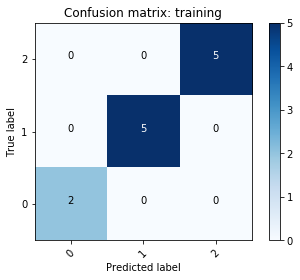

In [5]:
_ = model.plot_cm(dataset='training')

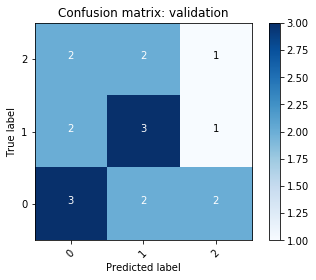

In [6]:
_ = model.plot_cm(dataset='validation')

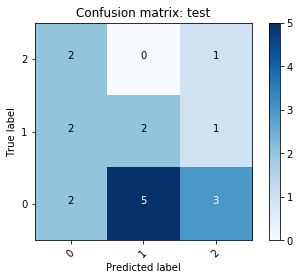

In [7]:
_ = model.plot_cm(dataset='test')